In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from matplotlib.colors import LinearSegmentedColormap
from sklearn.datasets import make_moons
# PyTorch
import torch

In [2]:
regression_lengthscale1_preds = torch.load('regression_lengthscale1_preds.pt', weights_only=False)
regression_lengthscale2_preds = torch.load('regression_lengthscale2_preds.pt', weights_only=False)
regression_elbo_mean = torch.load('regression_elbo_mean.pt', weights_only=False)
regression_elbo_samples = torch.load('regression_elbo_samples.pt', weights_only=False)
regression_de_elbo_mean = torch.load('regression_de_elbo_mean.pt', weights_only=False)
regression_de_elbo_samples = torch.load('regression_de_elbo_samples.pt', weights_only=False)
regression_gp_preds = torch.load('regression_gp_preds.pt', weights_only=False)
regression_gp_samples = torch.load('regression_gp_samples.pt', weights_only=False)

In [3]:
classification_lengthscale1_preds = torch.load('classification_lengthscale1_preds.pt', weights_only=False)
classification_lengthscale2_preds = torch.load('classification_lengthscale2_preds.pt', weights_only=False)
classification_elbo_mean = torch.load('classification_elbo_mean.pt', weights_only=False)
classification_elbo_samples = torch.load('classification_elbo_samples.pt', weights_only=False)
classification_de_elbo_mean = torch.load('classification_de_elbo_mean.pt', weights_only=False)
classification_de_elbo_samples = torch.load('classification_de_elbo_samples.pt', weights_only=False)
classification_gp_preds = torch.load('classification_gp_preds.pt', weights_only=False)
classification_gp_samples = torch.load('classification_gp_samples.pt', weights_only=False)
classification_gp_mean = torch.load('classification_gp_mean.pt', weights_only=False)

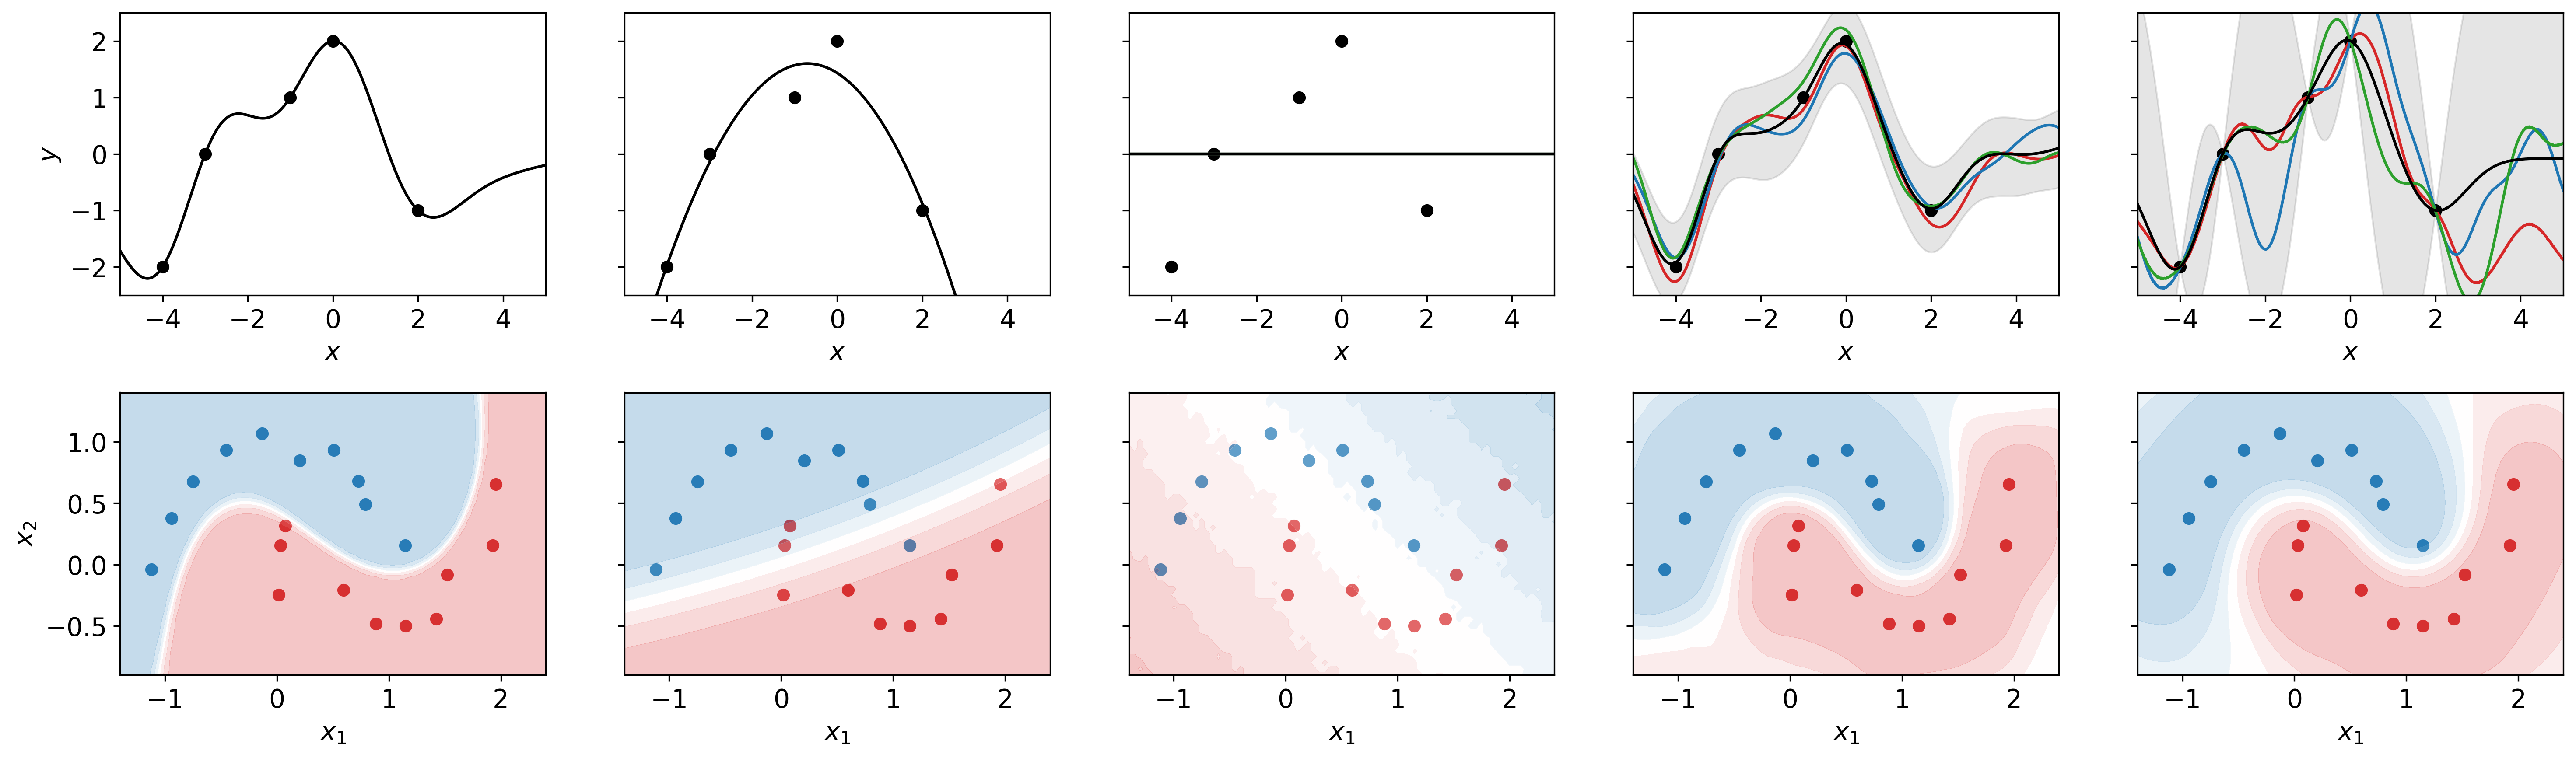

In [4]:
colors = ['#1F77B4', '#5799C7', '#8FBBDA', '#C7DDED', '#FFFFFF', '#F5C9CA', '#EB9394', '#E15D5E', '#D62728']
cmap = LinearSegmentedColormap.from_list('bwr', colors)

linspace = np.linspace(start=-5, stop=5, num=1000)
xx, yy = np.meshgrid(np.arange(-1.4, 2.5, 0.05), np.arange(-0.9, 1.5, 0.05))

ncols, nrows = 5, 2
fig, axs = plt.subplots(dpi=300, figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharey='row')

X_numpy, y_numpy = np.array([[-4], [-3], [-1], [0], [2]]), np.array([-2, 0, 1, 2, -1])

axs[0,0].scatter(X_numpy, y_numpy, color='#000000')
axs[0,0].plot(linspace, regression_lengthscale1_preds, color='#000000')
axs[0,0].set_xlim([-5, 5])
axs[0,0].set_ylim([-2.5, 2.5])
axs[0,0].set_xlabel(r'$x$')
axs[0,0].set_ylabel(r'$y$')

axs[0,1].scatter(X_numpy, y_numpy, color='#000000')
axs[0,1].plot(linspace, regression_lengthscale2_preds, color='#000000')
axs[0,1].set_xlim([-5, 5])
axs[0,1].set_ylim([-2.5, 2.5])
axs[0,1].set_xlabel(r'$x$')

axs[0,2].scatter(X_numpy, y_numpy, color='#000000')
axs[0,2].fill_between(linspace, regression_elbo_samples.mean(dim=0)+3*regression_elbo_samples.std(dim=0), regression_elbo_samples.mean(dim=0)-3*regression_elbo_samples.std(dim=0), alpha=0.1, color='#000000')
axs[0,2].plot(linspace, regression_elbo_samples[0], color='#D62728')
axs[0,2].plot(linspace, regression_elbo_samples[1], color='#1F77B4')
axs[0,2].plot(linspace, regression_elbo_samples[2], color='#2CA02C')
axs[0,2].plot(linspace, regression_elbo_mean, color='#000000')
axs[0,2].set_xlim([-5, 5])
axs[0,2].set_ylim([-2.5, 2.5])
axs[0,2].set_xlabel(r'$x$')

axs[0,3].scatter(X_numpy, y_numpy, color='#000000')
axs[0,3].fill_between(linspace, regression_de_elbo_samples.mean(dim=0)+3*regression_de_elbo_samples.std(dim=0), regression_de_elbo_samples.mean(dim=0)-3*regression_de_elbo_samples.std(dim=0), alpha=0.1, color='#000000')
axs[0,3].plot(linspace, regression_de_elbo_samples[0], color='#D62728')
axs[0,3].plot(linspace, regression_de_elbo_samples[1], color='#1F77B4')
axs[0,3].plot(linspace, regression_de_elbo_samples[2], color='#2CA02C')
axs[0,3].plot(linspace, regression_de_elbo_mean, color='#000000')
axs[0,3].set_xlim([-5, 5])
axs[0,3].set_ylim([-2.5, 2.5])
axs[0,3].set_xlabel(r'$x$')

axs[0,4].scatter(X_numpy, y_numpy, color='#000000')
axs[0,4].fill_between(linspace, regression_gp_preds.mean+3*regression_gp_preds.stddev, regression_gp_preds.mean-3*regression_gp_preds.stddev, alpha=0.1, color='#000000')
axs[0,4].plot(linspace, regression_gp_samples[0], color='#D62728')
axs[0,4].plot(linspace, regression_gp_samples[1], color='#1F77B4')
axs[0,4].plot(linspace, regression_gp_samples[2], color='#2CA02C')
axs[0,4].plot(linspace, regression_gp_preds.mean, color='#000000')
axs[0,4].set_xlim([-5, 5])
axs[0,4].set_ylim([-2.5, 2.5])
axs[0,4].set_xlabel(r'$x$')

X_numpy, y_numpy = make_moons(n_samples=20, noise=0.1, random_state=42)

axs[1,0].scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
axs[1,0].scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
axs[1,0].contourf(xx, yy, classification_lengthscale1_preds, alpha=0.3, cmap=cmap)
axs[1,0].set_xlim([-1.4, 2.4])
axs[1,0].set_ylim([-0.9, 1.4])
axs[1,0].set_xlabel(r'$x_1$')
axs[1,0].set_ylabel(r'$x_2$')

axs[1,1].scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
axs[1,1].scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
axs[1,1].contourf(xx, yy, classification_lengthscale2_preds, alpha=0.3, cmap=cmap)
axs[1,1].set_xlim([-1.4, 2.4])
axs[1,1].set_ylim([-0.9, 1.4])
axs[1,1].set_xlabel(r'$x_1$')

axs[1,2].scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
axs[1,2].scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
axs[1,2].contourf(xx, yy, classification_elbo_samples.mean(dim=0), alpha=0.3, cmap=cmap)
axs[1,2].set_xlim([-1.4, 2.4])
axs[1,2].set_ylim([-0.9, 1.4])
axs[1,2].set_xlabel(r'$x_1$')

axs[1,3].scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
axs[1,3].scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
axs[1,3].contourf(xx, yy, classification_de_elbo_samples.mean(dim=0), alpha=0.3, cmap=cmap)
axs[1,3].set_xlim([-1.4, 2.4])
axs[1,3].set_ylim([-0.9, 1.4])
axs[1,3].set_xlabel(r'$x_1$')

axs[1,4].scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
axs[1,4].scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
axs[1,4].contourf(xx, yy, classification_gp_mean, alpha=0.3, cmap=cmap)
axs[1,4].set_xlim([-1.4, 2.4])
axs[1,4].set_ylim([-0.9, 1.4])
axs[1,4].set_xlabel(r'$x_1$')

fig.tight_layout()
fig.savefig('regression_classification_demo.pdf', bbox_inches='tight')
plt.show()